In [54]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image
from torchvision.io import read_image
from torchvision import transforms
from PIL import Image
from collections import Counter

import os
import sys
import json
import random as rnd

1. dataset overview

Text(0, 0.5, 'Count')

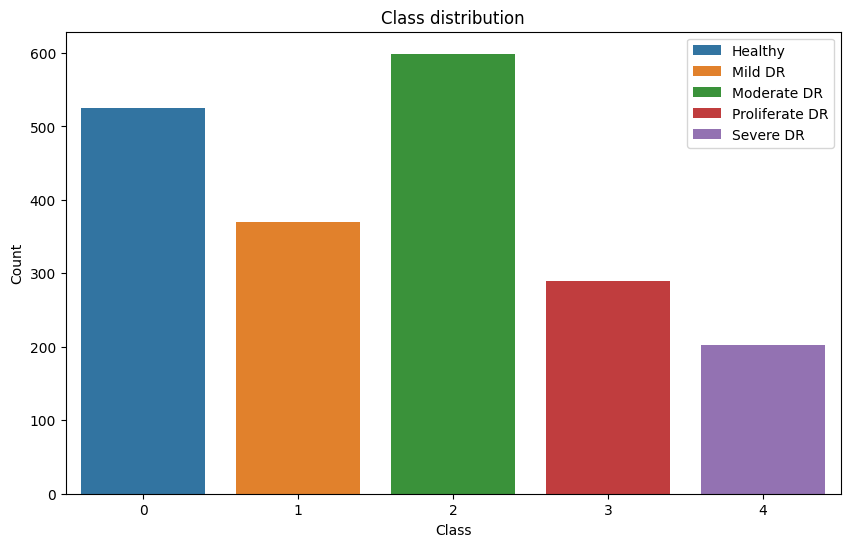

In [13]:
DS_DIR = "../data"

dataset = datasets.ImageFolder(DS_DIR)

classes = dataset.classes
class_ids = dataset.class_to_idx
counter = Counter(dataset.targets)

plt.figure(figsize=(10, 6))
sns.barplot(x=counter.keys(), y=counter.values(), hue=classes)

plt.title("Class distribution")
plt.xlabel("Class")
plt.ylabel("Count")

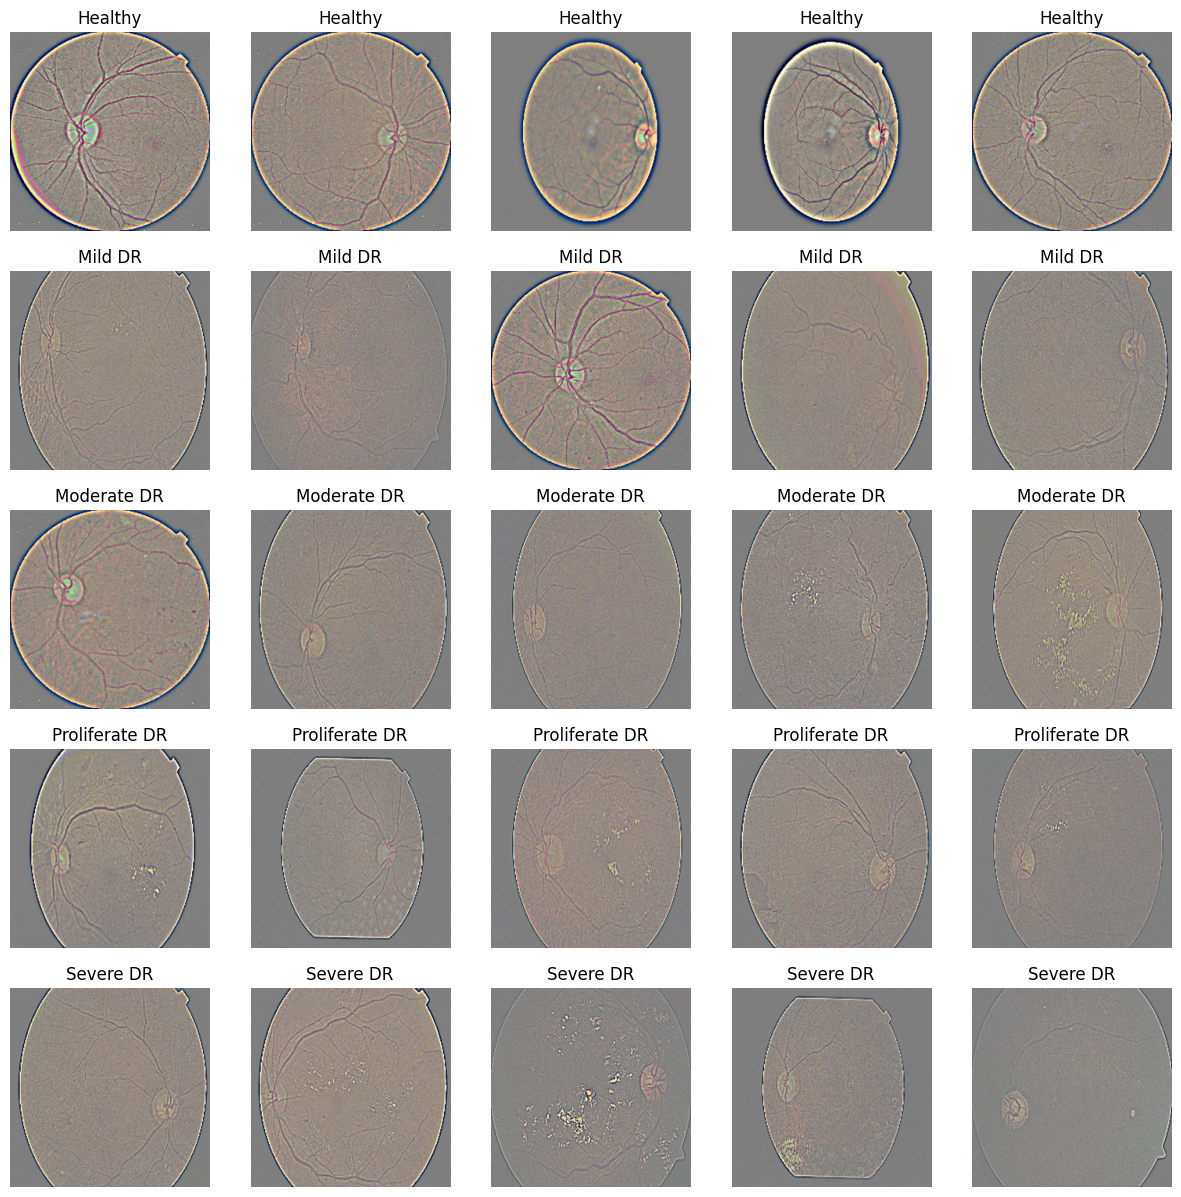

In [17]:
imgs_by_class = {cls: [] for cls in classes}

for path, label in dataset.samples:
    cls = classes[label]
    imgs_by_class[cls].append(path)

num_samples = 5
plt.figure(figsize=(num_samples * 3, len(classes) * 3))

i = 1
for cls in classes:
    samples = rnd.sample(imgs_by_class[cls], k=num_samples)
    for img_path in samples:
        img = to_pil_image(read_image(img_path))

        plt.subplot(len(classes), num_samples, i)
        plt.imshow(img)
        plt.axis("off")
        plt.title(cls)
        i += 1

plt.show()

2. baseline model results

In [ ]:
METRICS_PATH = "../results/metrics_baseline(21-11_01-35).json"
metrics_df = pd.read_json(METRICS_PATH)
n = len(metrics_df)
epochs = list(range(n))
metrics_df

,train_loss,val_loss,val_acc,val_precision,val_recall,val_f1
0,1.363833,1.272783,0.400673,0.531740,0.434487,0.358871
1,1.205350,1.233361,0.461279,0.465799,0.460834,0.429332
2,1.139751,1.176317,0.511785,0.554801,0.494176,0.456518
3,1.094206,1.146992,0.545455,0.546658,0.511793,0.468677
4,1.070184,1.135672,0.548822,0.551277,0.546642,0.514698
5,1.042532,1.134194,0.575758,0.539395,0.535251,0.532579
6,1.011788,1.223253,0.572391,0.535793,0.518548,0.506850
7,1.010741,1.260698,0.521886,0.584656,0.516811,0.489510
8,0.981878,1.092505,0.599327,0.572837,0.555023,0.518819
9,0.935826,1.142081,0.572391,0.554951,0.548746,0.538033


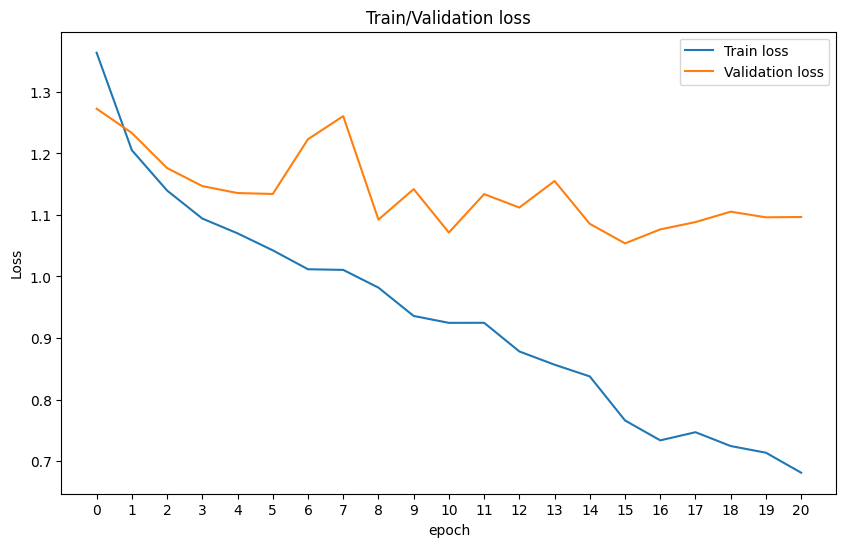

In [35]:
# loss visualisation
plt.figure(figsize=(10, 6))
sns.lineplot(x=epochs, y=metrics_df["train_loss"], label="Train loss")
sns.lineplot(x=epochs, y=metrics_df["val_loss"], label="Validation loss")

plt.xticks(epochs)
plt.title("Train/Validation loss")
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

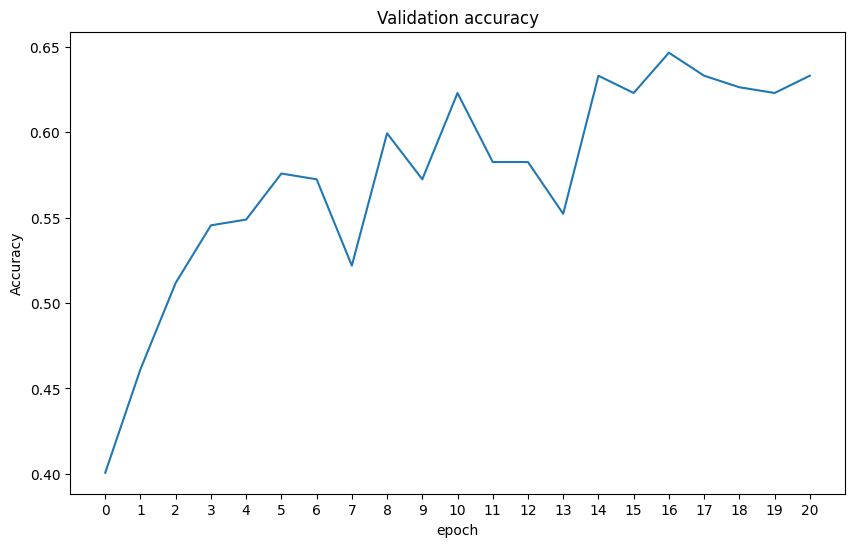

In [32]:
# val_acc
plt.figure(figsize=(10, 6))
sns.lineplot(x=epochs, y=metrics_df["val_acc"])

plt.xticks(epochs)
plt.title("Validation accuracy")
plt.ylabel("Accuracy")
plt.xlabel("epoch")
plt.show()

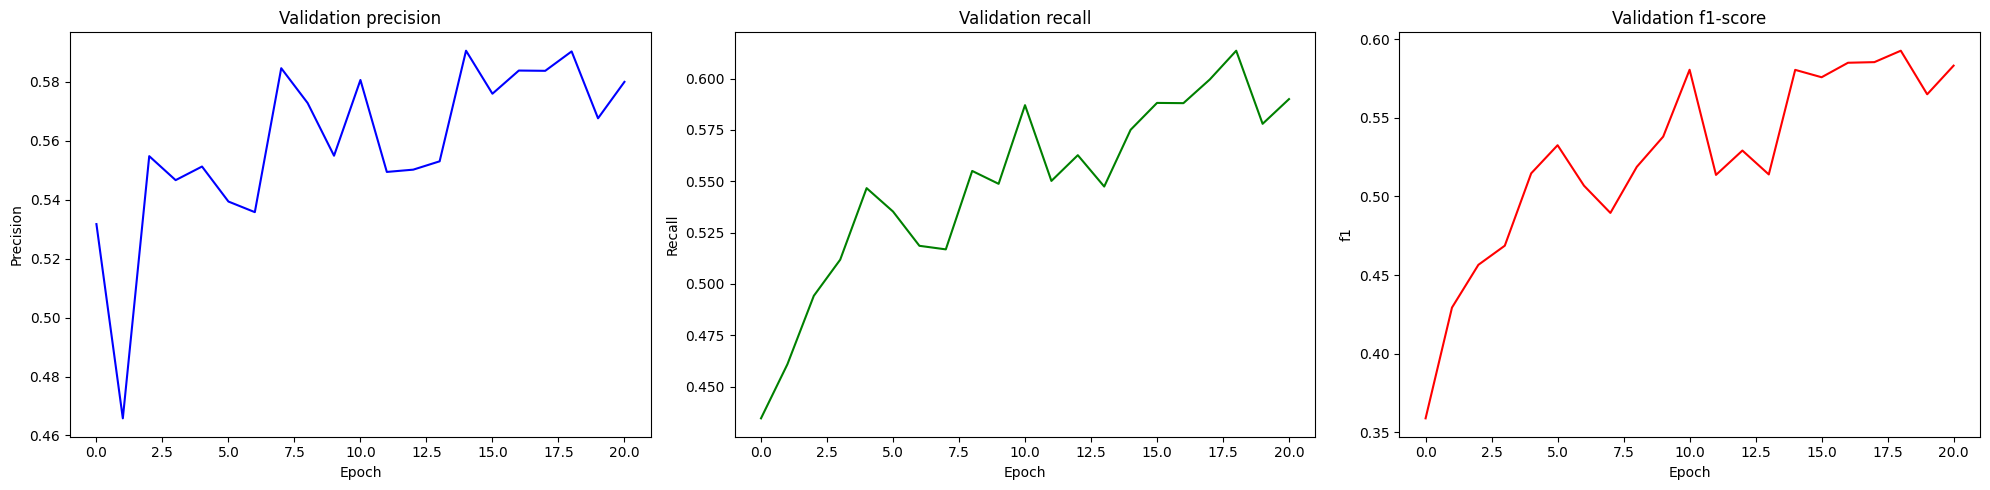

In [37]:
# val_precision	val_recall	val_f1 visualisation
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

sns.lineplot(ax=axes[0], x=epochs, y=metrics_df["val_precision"], color="blue")
axes[0].set_title("Validation precision")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Precision")

sns.lineplot(ax=axes[1], x=epochs, y=metrics_df["val_recall"], color="green")
axes[1].set_title("Validation recall")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Recall")

sns.lineplot(ax=axes[2], x=epochs, y=metrics_df["val_f1"], color="red")
axes[2].set_title("Validation f1-score")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("f1")

plt.tight_layout()
plt.show()

3. Model predictions

In [55]:
sys.path.append(os.path.abspath(".."))
from models.baseline_cnn import BaseLineCNN
from training.data_processor import DataProcessor

CHECKPOINT_PATH="../checkpoints/checkpoint_21-11_01-35.pth"
checkpoint = torch.load(CHECKPOINT_PATH, map_location="cuda")
model = BaseLineCNN(len(classes))
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BaseLineCNN(
  (featuresExtraction): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(256, 512, kernel_size=(3, 3), stride=(

In [71]:
from training.config import (
    BATCH_SIZE, MANUAL_SEED, IMAGE_SIZE, TRAIN_VAL_TEST_SPLIT
)

processor = DataProcessor(
    data_path="../data",
    image_size=IMAGE_SIZE,
    train_val_test_split=(TRAIN_VAL_TEST_SPLIT),
    manual_seed=MANUAL_SEED
)
_, _, ds = processor.process(
    batch_size=BATCH_SIZE,
    use_augmentation=False,
)
data_loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=3)

In [72]:
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in data_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)

        all_probs.append(probs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_probs = np.concatenate(all_probs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

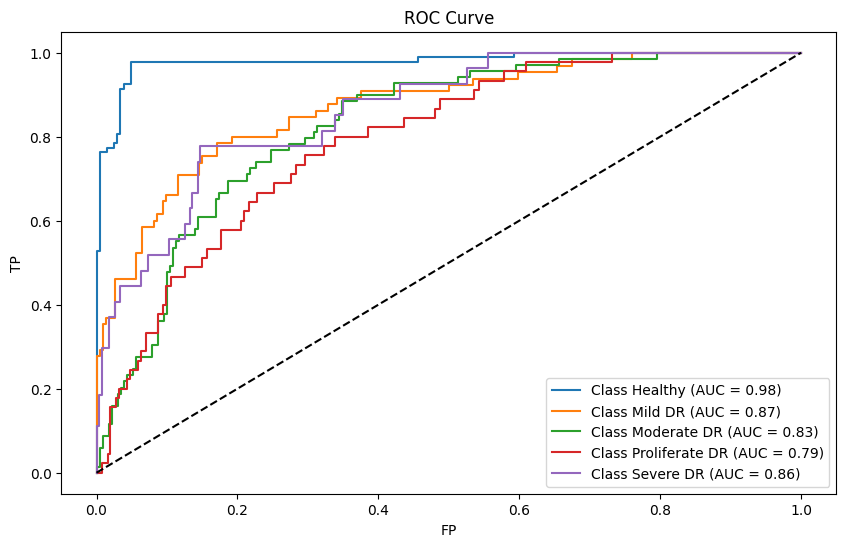

In [73]:
# ROC Curve
plt.figure(figsize=(10, 6))
for i, label in enumerate(classes):
    fpr, tpr, _ = roc_curve((all_labels == i).astype(int), all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {label} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('FP')
plt.ylabel('TP')
plt.title('ROC Curve')
plt.legend()
plt.show()

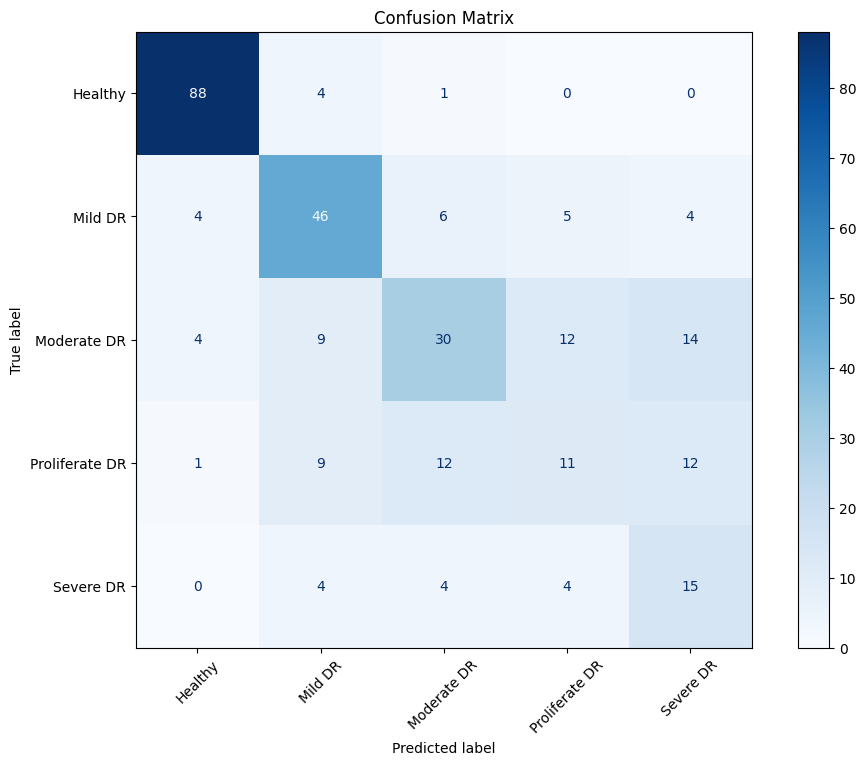

In [74]:
preds = np.argmax(all_probs, axis=1)
conf_matrx = confusion_matrix(all_labels, preds)

fig, ax = plt.subplots(figsize=(12, 8))
disp = ConfusionMatrixDisplay(conf_matrx, display_labels=classes)
disp.plot(cmap='Blues', ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()